# Apply Kernel Separable NMF on Real Data

This notebook loads the real dataset (`Neurips_preprocessed.csv`), computes a Gaussian kernel matrix, and applies the kernel separable NMF algorithm (using the reference code provided earlier). 

The results are visualized with:
  - A convergence plot (norm of the diagonal of the factor matrix vs. iteration)
  - A plot of the evolution of the mean gap between groups of the sorted diagonal values

In [444]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances


def project_onto_Sigma(X):
    """
    Project X onto the set Ω = {X | X >= 0, X(i,j) ≤ X(i,i) ≤ 1}.
    """
    n = X.shape[0]
    for i in range(n):
        X[i, :] = np.maximum(X[i, :], 0)
        X[i, :] = np.minimum(X[i, :], X[i, i])
        X[i, i] = min(X[i, i], 1.0)
    return X

def kernel_matrix(X, sigma=1.0):
    """
    Compute the Gaussian (RBF) kernel matrix for data X.
    """
    D = euclidean_distances(X, X)
    K = np.exp(-D**2 / (2 * sigma**2))
    return K

def mean_groups_diff(X):
    """
    Compute the difference between the means of two groups of diagonal values of X,
    where the groups are defined by the largest gap in the sorted diagonal.
    """
    diag_X = np.diag(X)
    sorted_diag = np.sort(diag_X)[::-1]
    diffs = sorted_diag[:-1] - sorted_diag[1:]
    gap_index = np.argmax(diffs)
    large_group = sorted_diag[:gap_index+1]
    small_group = sorted_diag[gap_index+1:]
    mean_large = np.mean(large_group)
    mean_small = np.mean(small_group)
    return mean_large - mean_small

def group_gap(X):
    """
    Compute the largest gap between consecutive sorted diagonal entries of X.
    """
    diag_X = np.diag(X)
    sorted_diag = np.sort(diag_X)[::-1]
    diffs = sorted_diag[:-1] - sorted_diag[1:]
    gap = np.max(diffs)
    return gap

def kernel_separable_nmf(K, lambda_param=1.0, max_iter=100, r=3, verbose=False, tol=1e-3, gap_tolerance=None, min_iter=20):
    """
    Perform the kernel separable NMF algorithm on a kernel matrix K.
    
    Parameters:
        K            : (n x n) kernel matrix
        lambda_param : Regularization parameter
        max_iter     : Maximum number of iterations
        r            : Number of anchors to select
        verbose      : If True, print progress information
        tol          : Convergence threshold (relative change in diag(X))
        gap_tolerance: Optional threshold on the gap between groups (if reached, stop early)
        min_iter     : Minimum number of iterations to force before checking for convergence
    
    Returns:
        X             : Final matrix X
        indices       : Indices corresponding to the r largest diagonal entries of X
        diag_norms    : List of the diagonal vectors (one per iteration)
        mean_diffs    : List of mean differences between groups (one per iteration)
    """
    n = K.shape[0]
    X = np.random.rand(n, n)
    I = np.eye(n)
    epsilon = 1e-10
    diag_norms = []
    mean_diffs = []
    prev_diag = None
    
    for it in range(max_iter):
        KX = K @ X
        denom = 2 * lambda_param * KX + epsilon
        numerator = 2 * lambda_param * K - I
        update_factor = numerator / denom
        X = X * update_factor
        
        # Project X onto the feasible set: X >= 0, X(i,j) <= X(i,i) <= 1
        X = project_onto_Sigma(X)
        
        X_diag = np.diag(X)
        diag_norms.append(X_diag.copy())
        mean_diffs.append(mean_groups_diff(X))
        
        if prev_diag is not None:
            # Use relative change instead of absolute change to avoid premature stopping
            rel_diff = np.linalg.norm(X_diag - prev_diag) / (np.linalg.norm(prev_diag) + epsilon)
            if it >= min_iter and rel_diff < tol:
                if verbose:
                    print(f"Converged at iteration {it} with relative diagonal diff={rel_diff:.6e}")
                break
        
        if gap_tolerance is not None:
            gap = group_gap(X)
            if gap > gap_tolerance:
                if verbose:
                    print(f"Converged at iteration {it} with gap={gap:.6e}")
                break
        
        prev_diag = X_diag.copy()
        
        if verbose and (it % 10 == 0 or it == max_iter - 1):
            norm_diag = np.linalg.norm(X_diag)
            print(f"Iteration {it}: ||diag(X)|| = {norm_diag:.4f}")
    
    final_diag = np.diag(X)
    indices = np.argsort(final_diag)[-r:][::-1]
    return X, indices, diag_norms, mean_diffs



## Load and Preprocess Data

Load the CSV file and select only numeric columns. (If there are non-numeric features that you need to use, consider encoding them.)

Note: Typically, in many datasets rows are data points. In separable NMF the theory assumes that each
column is a data point. Here, we assume rows are data points and compute the kernel matrix accordingly.

In [445]:
# Load the real data
data = pd.read_csv('Neurips_preprocessed.csv')
print('Data shape:', data.shape)

# Select only numeric columns
numeric_data = data.select_dtypes(include=[np.number])
print('Numeric data shape:', numeric_data.shape)

# Convert to numpy array
X_data = numeric_data.values

# If rows are data points, then our kernel matrix will be computed over rows
print('X_data shape (rows=data points):', X_data.shape)

Data shape: (245, 997)
Numeric data shape: (245, 995)
X_data shape (rows=data points): (245, 995)


In [446]:
# Compute the kernel matrix (using a Gaussian/RBF kernel; adjust sigma as needed)
sigma = 10  # adjust sigma if needed
K = kernel_matrix(X_data, sigma=sigma)
lambda_param = 50
# Print the diagonal of (2 * lambda_param * K - I)
print("Diagonal of (2 * lambda_param * K - I):", np.diag(2 * lambda_param * K - np.eye(K.shape[0])))


Diagonal of (2 * lambda_param * K - I): [99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99.
 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99.
 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99.
 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99.
 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99.
 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99.
 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99.
 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99.
 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99.
 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99.
 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99.
 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99.
 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99.
 99. 99. 99

## Run the Kernel Separable NMF Algorithm

We run the algorithm on the kernel matrix. Here, we set the number of expected anchors `r` (e.g., 4).
You can adjust `lambda_param`, `max_iter`, and `r` as needed.

In [447]:
# Set algorithm parameters
lambda_param = 20
max_iter = 1000
r = 5  # Number of anchors to select

# Run the algorithm
X_final, anchor_indices, diag_norms, mean_diffs = kernel_separable_nmf(K, lambda_param=lambda_param, max_iter=max_iter, r=r, verbose=True, tol=1e-6, gap_tolerance=0.5)


print("\nSelected anchor indices:")
print(anchor_indices)
print(f"Total anchors found: {len(anchor_indices)}")

Iteration 0: ||diag(X)|| = 14.6591
Iteration 10: ||diag(X)|| = 15.2366
Iteration 20: ||diag(X)|| = 15.2476
Iteration 30: ||diag(X)|| = 15.2511
Iteration 40: ||diag(X)|| = 15.2528
Iteration 50: ||diag(X)|| = 15.2537
Iteration 60: ||diag(X)|| = 15.2543
Iteration 70: ||diag(X)|| = 15.2547
Iteration 80: ||diag(X)|| = 15.2550
Iteration 90: ||diag(X)|| = 15.2552
Iteration 100: ||diag(X)|| = 15.2554
Iteration 110: ||diag(X)|| = 15.2555
Iteration 120: ||diag(X)|| = 15.2555
Iteration 130: ||diag(X)|| = 15.2556
Iteration 140: ||diag(X)|| = 15.2557
Converged at iteration 146 with relative diagonal diff=9.992821e-07

Selected anchor indices:
[  0  57 174 100  99]
Total anchors found: 5


## Visualize Convergence

Below are two plots:

1. **Norm of Diagonal vs. Iteration:** Tracks the convergence of the algorithm.
2. **Mean Gap vs. Iteration:** Shows how the difference between the means of the two groups (as determined by the largest gap in the sorted diagonal) evolves.

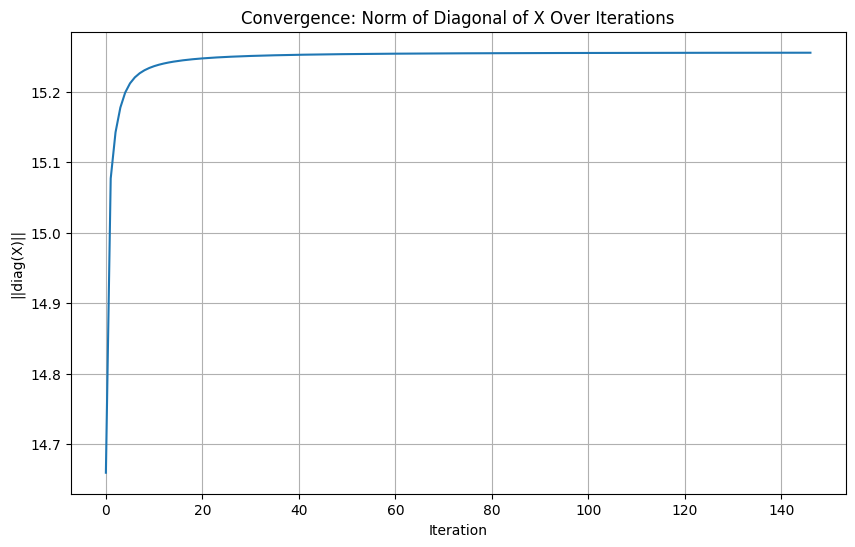

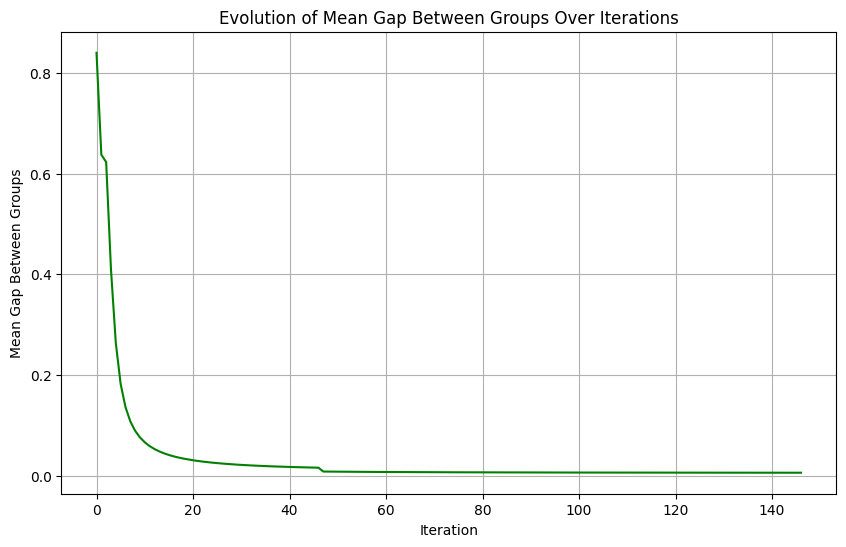

In [448]:
# Plot the norm of the diagonal of X over iterations
norms = [np.linalg.norm(d) for d in diag_norms]
plt.figure(figsize=(10, 6))
plt.plot(norms)
plt.xlabel('Iteration')
plt.ylabel('||diag(X)||')
plt.title('Convergence: Norm of Diagonal of X Over Iterations')
plt.grid(True)
plt.show()

# Plot the evolution of the mean gap between groups
plt.figure(figsize=(10, 6))
plt.plot(mean_diffs, color='green')
plt.xlabel('Iteration')
plt.ylabel('Mean Gap Between Groups')
plt.title('Evolution of Mean Gap Between Groups Over Iterations')
plt.grid(True)
plt.show()

## Analysis of Diagonal Values

We now sort the final diagonal entries of X and compute the consecutive differences. A large gap
after the top entries is expected if the selected anchors (key factors) are well separated.

In [449]:
# Analyze sorted diagonal entries
diag_X = np.diag(X_final)
sorted_diag = np.sort(diag_X)[::-1]
diffs = sorted_diag[:-1] - sorted_diag[1:]
gap = np.max(diffs)

print("Sorted diagonal entries:")
print(sorted_diag)
print("\nConsecutive differences:")
print(diffs)
print("\nLargest gap (indicator of anchor separation):")
print(gap)

Sorted diagonal entries:
[0.975      0.975      0.975      0.975      0.975      0.975
 0.975      0.975      0.975      0.975      0.975      0.975
 0.975      0.975      0.975      0.975      0.975      0.975
 0.975      0.975      0.975      0.975      0.975      0.975
 0.975      0.975      0.975      0.975      0.975      0.975
 0.975      0.975      0.975      0.975      0.975      0.975
 0.975      0.975      0.975      0.975      0.975      0.975
 0.975      0.975      0.975      0.975      0.975      0.975
 0.975      0.975      0.975      0.975      0.975      0.975
 0.975      0.975      0.975      0.975      0.975      0.975
 0.975      0.975      0.975      0.975      0.975      0.975
 0.975      0.975      0.975      0.975      0.975      0.975
 0.975      0.975      0.975      0.975      0.975      0.975
 0.975      0.975      0.975      0.975      0.975      0.975
 0.975      0.975      0.975      0.975      0.975      0.975
 0.975      0.975      0.975      0.975      